Data Loading


In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
apple_df = pd.read_csv('AAPL.csv')

In [4]:
apple_df.shape

(251, 7)

In [5]:
apple_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-15,209.220001,210.740005,208.330002,210.240005,207.027420,28807600
1,2018-08-16,211.750000,213.809998,211.470001,213.320007,210.060333,28500400
2,2018-08-17,213.440002,217.949997,213.160004,217.580002,214.255234,35427000
3,2018-08-20,218.100006,219.179993,215.110001,215.460007,212.167633,30287700
4,2018-08-21,216.800003,217.190002,214.029999,215.039993,211.754028,26159800


Data Pre-Processing

In [6]:
#checking for null values
apple_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [8]:
#converting the dataype of 'Date' col to 'datetime'
apple_df['Date'] = pd.to_datetime(apple_df['Date'])

In [9]:
#making the 'Date' col as index
apple_df.set_index('Date', inplace = True)

In [10]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-08-15 to 2019-08-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       251 non-null    float64
 1   High       251 non-null    float64
 2   Low        251 non-null    float64
 3   Close      251 non-null    float64
 4   Adj Close  251 non-null    float64
 5   Volume     251 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [11]:
#sort the indexes
apple_df.sort_index(inplace = True)

In [12]:
apple_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,209.220001,210.740005,208.330002,210.240005,207.027420,28807600
2018-08-16,211.750000,213.809998,211.470001,213.320007,210.060333,28500400
2018-08-17,213.440002,217.949997,213.160004,217.580002,214.255234,35427000
2018-08-20,218.100006,219.179993,215.110001,215.460007,212.167633,30287700
2018-08-21,216.800003,217.190002,214.029999,215.039993,211.754028,26159800


In [13]:
# Apply log transformation to Volume to stabilize variance
apple_df['Log_Volume'] = np.log(apple_df['Volume'])

In [14]:
#deleting the original column of volume
apple_df.drop(columns = ['Volume'], inplace = True)

In [15]:
apple_df.head()


,Open,High,Low,Close,Adj Close,Log_Volume
Date,,,,,,
2018-08-15,209.220001,210.740005,208.330002,210.240005,207.027420,17.176150
2018-08-16,211.750000,213.809998,211.470001,213.320007,210.060333,17.165429
2018-08-17,213.440002,217.949997,213.160004,217.580002,214.255234,17.382985
2018-08-20,218.100006,219.179993,215.110001,215.460007,212.167633,17.226252
2018-08-21,216.800003,217.190002,214.029999,215.039993,211.754028,17.079734


In [16]:
#normalizing the data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(apple_df[apple_df.columns])

In [17]:
scaled_values

array([[0.75161293, 0.74096871, 0.75563913, 0.7571206 , 0.75577275,
        0.43543352],
       [0.78076039, 0.77595438, 0.79141036, 0.79138853, 0.79023062,
        0.43041578],
       [0.80023046, 0.82313386, 0.81066308, 0.838785  , 0.83789019,
        0.53223737],
       ...,
       [0.64101379, 0.64193734, 0.65105941, 0.64853127, 0.68138544,
        0.31925107],
       [0.65714293, 0.75692305, 0.66621094, 0.7429906 , 0.77784302,
        0.66670621],
       [0.6817973 , 0.69196582, 0.69024831, 0.67378721, 0.70717566,
        0.54560053]])

In [18]:
#converting the array into dataframe
apple_scaled_df = pd.DataFrame(scaled_values, columns = apple_df.columns, index = apple_df.index)

In [19]:
apple_scaled_df.head()

,Open,High,Low,Close,Adj Close,Log_Volume
Date,,,,,,
2018-08-15,0.751613,0.740969,0.755639,0.757121,0.755773,0.435434
2018-08-16,0.780760,0.775954,0.791410,0.791389,0.790231,0.430416
2018-08-17,0.800230,0.823134,0.810663,0.838785,0.837890,0.532237
2018-08-20,0.853917,0.837151,0.832878,0.815198,0.814172,0.458883
2018-08-21,0.838940,0.814473,0.820574,0.810525,0.809473,0.390309


Plotting the Column


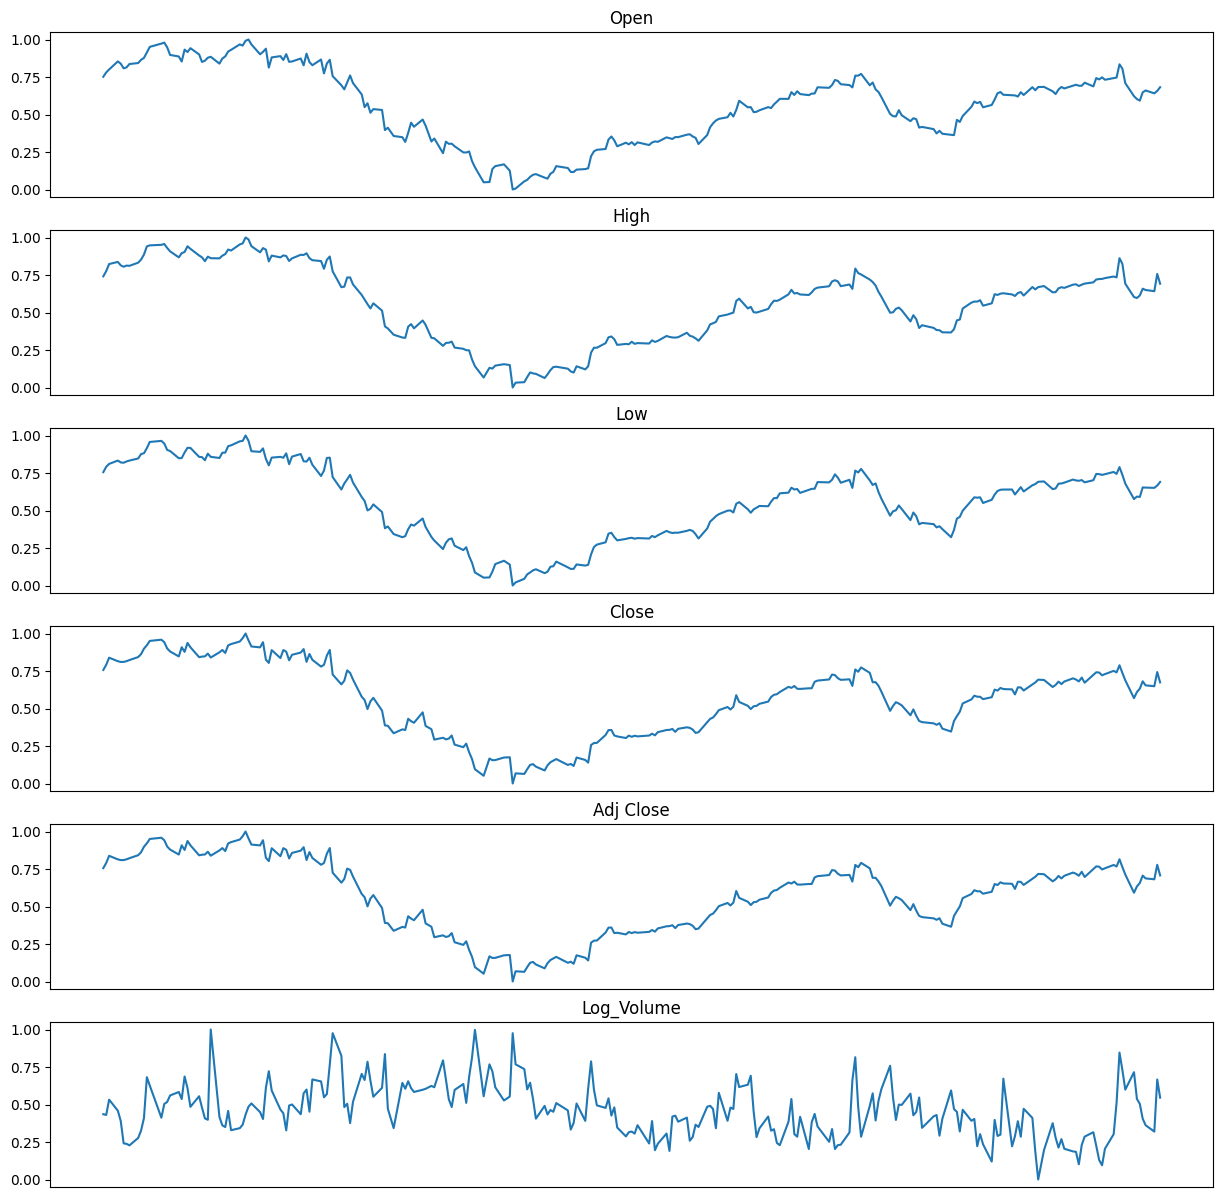

In [20]:
plt.rcParams['figure.figsize'] = (15, 15)
figure, axes = plt.subplots(6)

for ax, col in zip(axes, apple_scaled_df.columns):
  ax.plot(apple_scaled_df[col])
  ax.set_title(col)
  ax.axes.xaxis.set_visible(False)

Creating the sliding window sequence

In [21]:
window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

X, y = create_sequence(apple_scaled_df, window_size)

In [22]:
X.shape, y.shape

((191, 60, 6), (191, 6))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((152, 60, 6), (152, 6), (39, 60, 6), (39, 6))

In [24]:
X_train.shape[1], X_train.shape[2], y_train.shape[1]

(60, 6, 6)

Building the LSTM Model


In [25]:
model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer
    keras.layers.Dense(y_train.shape[1])
])

c:\Users\Divya Patil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

In [27]:
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [28]:
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - RootMeanSquaredError: 0.2926 - loss: 0.0874 - val_RootMeanSquaredError: 0.1778 - val_loss: 0.0316
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - RootMeanSquaredError: 0.1871 - loss: 0.0352 - val_RootMeanSquaredError: 0.1180 - val_loss: 0.0139
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - RootMeanSquaredError: 0.1636 - loss: 0.0270 - val_RootMeanSquaredError: 0.1032 - val_loss: 0.0106
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - RootMeanSquaredError: 0.1536 - loss: 0.0236 - val_RootMeanSquaredError: 0.1069 - val_loss: 0.0114
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - RootMeanSquaredError: 0.1514 - loss: 0.0230 - val_RootMeanSquaredError: 0.1065 - val_loss: 0.0113
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - RootMeanSquaredError: 0.1360 - loss: 0.0186 - val_RootMeanSquaredError: 0.1023 - val_loss: 0.0105
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - RootMeanSquaredError: 0.1320 -

In [29]:
# Making predictions on the test data
predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


In [30]:
# Inverse scaling to get the original values
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)